## Easy-to-use Gamma Filter Implementations
#### The code corresponds to the paper ['The Gamma Filter-A New Class of Adaptive IIR Filters with Restricted Feedback'](http://www.cnel.ufl.edu/courses/EEL6502/principe_gamma_1993.pdf/). 

### 1. Showing the Optimal $\mu$ (Fig. 4 in the paper).

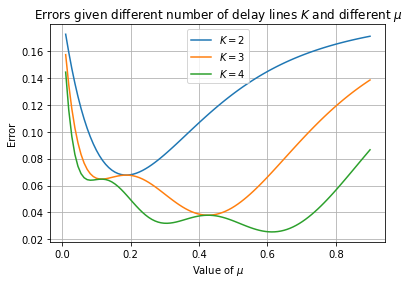

In [9]:
import numpy as np

#### THE OPTIMAL WEIGHTS WILL BE GIVEN BY WIENER-HOPF EQUATION (EQ. 22)
class wf_layer_WIENERSOLUTION():
    def __init__(self, N):
        self.weights = None
        
    def forward(self, x):
        x_ = np.concatenate((np.ones((x.shape[0], 1)), x), 1)
        
        return self.weights@x_.T
    
    def train(self, x, desire_list):
        
        x_ = np.concatenate((np.ones((x.shape[0], 1)), x), 1)
        self.weights = desire_list.T@x_@np.linalg.pinv(x_.T@x_)
        return (x_.T@x_), desire_list.T@x_

K = 5 # TAP NUMBER
N = 10000 # LENGTH OF NOISE INPUT (FOR SYSTEM IDENTIFICATION)

np.random.seed(333)
v_t = np.random.normal(0, 1, 10000)

from scipy.signal import bessel, lsim, dlsim
import matplotlib.pyplot as plt
from scipy import signal

num = [0.0563, -0.0009, -0.0009, 0.0563] # COEFFICIENTS FOR TRANSFER FUNCTION
den = [1, -2.1291, 1.7834, -0.5435]
system = signal.TransferFunction(num, den, dt=0.1) # DEFINE TRANSFER FUNCTION
tout, target = dlsim(system, v_t) # GET OUTPUTS OF THE SYSTEM
    
error_list = []

for mu in np.linspace(0.01, 0.9, 100):
    num = [mu] # EACH MU DEFINES A DYNAMICAL SYSTEM
    den = [1, -(1-mu)]

    system = signal.TransferFunction(num, den, dt=0.1)
    
    tout, y_1 = dlsim(system, v_t) # OUTPUTS OF THE FOUR DELAY LINES
    tout, y_2 = dlsim(system, y_1)
    tout, y_3 = dlsim(system, y_2)
    tout, y_4 = dlsim(system, y_3)
    
    input_K = np.concatenate([v_t.reshape(-1, 1), y_1, y_2, y_3, y_4], 1) 
    
    for k in range(2, K):
    
        input = input_K[:, 0:k] # SUPPOSE THERE ARE ONLY K DELAY LINES 

        layer_f = wf_layer_WIENERSOLUTION(input.shape[0]) # COMPUTE WIENER SOLUTION
        layer_f.train((input), target.reshape(-1))
        predict = layer_f.forward((input))

        error = np.mean((predict.reshape(-1) - target.reshape(-1))**2) # COMPUTE ERROR
        error_list.append(error) 

resized = np.array(error_list).reshape(100, 3)
plt.plot(np.linspace(0.01, 0.9, 100), resized)
plt.xlabel('Value of $\mu$')
plt.ylabel('Error')
plt.title('Errors given different number of delay lines $K$ and different $\mu$')
plt.grid(b=None)
plt.legend(['$K=2$', '$K=3$', '$K=4$'])
plt.show()

### The optimal $\mu$ corresponds to the lowest error for each $L$!

### 2. LMS Updates (Section I.D in the paper).

#### Here we implement online updates/mini-batches updates with Pytorch. The final mapper is linear, which will match Wiener-Hopf equations. The codes can be extended to the nonlinear case.

TAP: 2 ITERATION: 1000
TAP: 2 ITERATION: 2000
TAP: 2 ITERATION: 3000
TAP: 3 ITERATION: 1000
TAP: 3 ITERATION: 2000
TAP: 3 ITERATION: 3000
TAP: 4 ITERATION: 1000
TAP: 4 ITERATION: 2000
TAP: 4 ITERATION: 3000


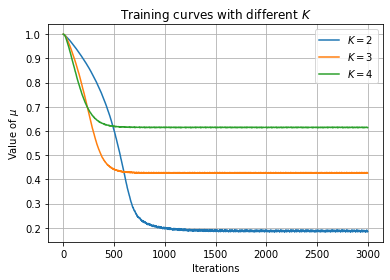

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from sklearn.linear_model import LinearRegression

import sklearn
from sklearn import datasets

from scipy.signal import bessel, lsim, dlsim
from scipy import signal

from torch.autograd import Variable

def apply_GZ(v_t, mu):
  y_1_p = []
  y_1_p.append(torch.FloatTensor([0]).float().cuda())
  for i in range(1, v_t.shape[0]):
    y_1_p.append((1-mu)*y_1_p[i-1] + mu*v_t[i-1])
  y_1_p = torch.stack(y_1_p)
  return y_1_p

# DEFINE GAMMA FILTER
class Gamma_filter_nonlinear(nn.Module):
    def __init__(self, tap = 2):
      super(Gamma_filter_nonlinear, self).__init__()
      self.tap = tap
      self.mu = nn.parameter.Parameter(torch.FloatTensor([1]), False)
      self.fc = nn.Linear(self.tap, 1, bias=True)

    def forward(self, x):
      output = []
      output.append(x)
      for i in range(0, self.tap-1):
        output.append(apply_GZ(output[-1], self.mu).reshape(-1))
      output = torch.stack(output).T
      output = self.fc(output)
      return output

def GD(net, lr):
    for param in net.parameters():
        if param.requires_grad:
            param.data = param.data - lr*param.grad
            
    net.zero_grad()
    return 0

def f_w_true(v_t, min=-0.2, max=0.3):
    return np.clip(v_t, min, max)

# THIS FUNCTION NORMALIZES THE SIGNAL TO HAVE THE MAXIMUM VALUE 1
def create_train_test_gamma(x, desire, shuffle):
  train_size = int(1*shuffle.shape[0]/2)

  x = (x - np.min(x, 0))/np.max((x - np.min(x, 0)), 0)
  desire = (desire - np.min(desire, 0))/np.max((desire - np.min(desire, 0)), 0)

  x = (x-0.5)*2
  desire = (desire-0.5)*2

  x_list = x[shuffle][0:train_size]
  x_list = x_list.reshape(x_list.shape[0], -1)
  label_list = np.array(desire)[shuffle].reshape(-1, 1)[0:train_size]

  desire_mean = np.mean(label_list)
  desire_std = np.std(label_list)
  label_list = (label_list-desire_mean)/desire_std
  DESIRE = label_list.reshape(-1, 1)

  x_test = x[shuffle][train_size:]
  x_test = x_test.reshape(x_test.shape[0], -1)
  test_label = np.array(desire)[shuffle].reshape(-1, 1)[train_size:]
  test_label = (test_label - desire_mean)/desire_std

  return x, desire, x_list, label_list, x_test, test_label, desire_std

# CHANGE THIS FUNCTION IF YOU WANT TO USE NEURAL NETWORKS OR ANY OTHER ARCHITECTURE
class WF_assignment(nn.Module):
    def __init__(self, N):
      super(WF_assignment, self).__init__()
      self.fc1 = nn.Linear(N, 1, bias=True)

    def forward(self, x):
      output = self.fc1(x)
      return output

# CONSTRUCT THE GRADIENT STEP BY STEP (EQ. 17)
def load_buffer(input, mu, buffer, alpha_buffer):

  buffer_init = torch.clone(buffer[:, -1].data)
  alpha_buffer_init = torch.clone(alpha_buffer[:, -1].data)

  #CHECK IF THE TIME STEP MATCHES:
  if buffer_init[0] != input[0]:
    print('buffer initial buffer:', buffer_init[0], 'input initial buffer:', input[0])
    raise ValueError('Initial value not match')

  ### reinitialization

  buffer.data.fill_(0)
  alpha_buffer_init.data.fill_(0)

  buffer[:, 0] = buffer_init
  alpha_buffer[:, 0] = alpha_buffer_init

  buffer[0] = input

  ### fill in the buffer

  for j in range(1, buffer.shape[1]):
    for i in range(1, buffer.shape[0]):
      buffer[i, j] = (1-mu)*buffer[i, j-1]+mu*buffer[i-1, j-1]
      alpha_buffer[i, j] = (1-mu)*alpha_buffer[i, j-1] + mu*alpha_buffer[i-1, j-1] + (buffer[i-1, j-1] - buffer[i, j-1])    

  return 0

def initial_buffer(input, mu, buffer, alpha_buffer):
  buffer[0, -1] = input[0] # intialize the first buffer
  load_buffer(input, mu, buffer, alpha_buffer)

  return 0

def GAMMA_ONLINE(x, desire, D = 6, tap = 5, seed = 0, iter = 80000, batch_size = 100, lr=0.1):

  np.random.seed(seed)
  shuffle = np.arange(0, x.shape[0])
  #np.random.shuffle(shuffle)

  x_, desire_, x_list, DESIRE, x_test, test_label, desire_std = create_train_test_gamma(x, desire, shuffle)

  DESIRE = DESIRE.reshape(-1, 1)
  torch.manual_seed(seed)
  np.random.seed(seed)

  net = WF_assignment(tap).cuda()

  mu_list = []

  ### TRAIN PROJECTION

  buffer = torch.zeros((tap, batch_size)).cuda()
  alpha_buffer = torch.zeros((tap, batch_size)).cuda()

  buffer.requires_grads = False
  alpha_buffer.requires_grads = False

  mu = nn.parameter.Parameter(torch.FloatTensor([1]), False).cuda() # initialize mu
  train_tensor = torch.FloatTensor(x_list).cuda().reshape(-1)
  label_tensor = torch.from_numpy(DESIRE).float().cuda().reshape(-1)

  time_index = 0
  i = 0

  for j in range(0, iter):
    i +=1 
    if (time_index+(batch_size-1)) >= train_tensor.shape[0]:
      start_point = np.random.choice(tap)
      time_index = start_point

      buffer.data.fill_(0)
      alpha_buffer.data.fill_(0)
      input = train_tensor[time_index:time_index+batch_size]
      initial_buffer(input, mu, buffer, alpha_buffer)

    elif j == 0:
      input = train_tensor[time_index:time_index+batch_size]
      initial_buffer(input, mu, buffer, alpha_buffer)

    else:
      input = train_tensor[time_index:time_index+batch_size]
      load_buffer(input, mu, buffer, alpha_buffer)
    
    x_train = buffer.detach().T
    y_train = label_tensor[time_index:time_index+batch_size].reshape(-1, 1)

    time_index+=(batch_size-1)

    x_train.requires_grad = True

    # COMPUTE GRADIENT
    output = (net(x_train))
    gradient_1 = torch.mean((output.view(-1) - y_train.view(-1))**2)
    (gradient_1).backward(torch.ones(gradient_1.shape).cuda(), retain_graph=True)

    # COMPUTE GRADIENT FOR MU
    mu_grad = torch.mean((alpha_buffer.T)*x_train.grad.data)
    mu.data = mu.data - lr*mu_grad

    # UPDATE WEIGHTS
    GD(net, lr)
    x_train.grad.data.zero_()

    x_train.requires_grad = False

    if mu.item()>1: mu.data.fill_(1)
    mu_list.append(mu.item())

    if i%1000 == 0:
      print('TAP:', tap, 'ITERATION:', i)

  return mu_list, net

# DEFINE OUR SYSTEM (THE SAME AS PREVIOUS)
num = [0.0563, -0.0009, -0.0009, 0.0563]
den = [1, -2.1291, 1.7834, -0.5435]
system = signal.TransferFunction(num, den, dt=0.1)
tout, target = dlsim(system, np.concatenate(([1], [0]*99)))

# CONSTRUCT GAUSSIAN RESPONSE FOIR IDENTIFICATION 
np.random.seed(333)
x_t = np.random.normal(0, 1, 10000)
tout, target = dlsim(system, x_t)

mu_list_ = []

# CHOOSING DEPTH (K - DELAY LINES)
for depth in [2, 3, 4]:
  x = x_t
  desire = target

  mu_list, net  = GAMMA_ONLINE(x, desire, tap = depth, D = 1, seed = 0, iter = 3000, batch_size = 100, lr=0.5)
  mu_list_.append(mu_list)
  
plt.plot(np.array(mu_list_).T)
plt.legend(['$K=2$', '$K=3$', '$K=4$'])
plt.xlabel('Iterations')
plt.ylabel('Value of $\mu$')
plt.title('Training curves with different $K$')
plt.grid(b=None)
plt.show()

Notice that:


1.   The intialization should be start with 1. With a greater $K$, the optimal $\mu$ is closer to $1$ to avoid the local minimum shown in the first figure. $\mu$ indicates the depth of the system. The system is stable when $\mu$ is between $0$ to $2$. But the optimum will always be below $1$.
2.   Increasing the batch size or using full-batch update can get rid of the noise in the training curves.
3.   You can compare whether $\mu$ converges to the optimal solution shown in the first figure. You can see indeed it converges to the global optimum.

